In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [3]:
import numpy as np
import geopandas as gpd
import rasterio
import xarray as xa
import rioxarray as rio
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pathlib import Path
import pathlib
from tqdm import tqdm
from scipy.ndimage import binary_dilation

import netCDF4

from coralshift.utils import file_ops, directories
from coralshift.dataloading import bathymetry
from coralshift.processing import data

In [48]:
test_arr = np.random.rand(100, 6, 50)
np.shape(test_arr)

(100, 6, 50)

In [51]:
hit = np.ones((50,1))
miss = np.zeros((50,1))
target = np.concatenate([hit, miss])

lstm_array = np.concatenate([test_arr, target], axis=2)
lstm_array

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [46]:
target.shape

(100, 1)

In [18]:
time = xa.cftime_range(start='2022-01-01', end='2022-01-05', freq='D')

# create lat and lon coordinates
lat = np.linspace(-90, 90, 5)
lon = np.linspace(-180, 180, 5)

# create random data for each coordinate
# create random data for each variable and coordinate
data1 = np.random.rand(len(time), len(lat), len(lon))
data2 = np.random.rand(len(time), len(lat), len(lon))
data3 = np.random.rand(len(time), len(lat), len(lon))

# create xarray dataset with time, lat, and lon as coordinates
ds = xa.Dataset({'data1': (['time', 'lat', 'lon'], data1),
                 'data2': (['time', 'lat', 'lon'], data2),
                 'data3': (['time', 'lat', 'lon'], data3)},
                coords={'time': time,
                        'lat': lat,
                        'lon': lon})


# stacked.transpose('time','points').as_numpy()

# np.shape(stacked['data1'].transpose('time','points').to_numpy())

def stacking(ds):
    stacked = ds.stack(points=('lat', 'lon'))
    
    vars_list = list(ds.variables)
    # stack= stacked[vars_list[0]].to_numpy()
    vals = []
    for d in vars_list[:3]:
        vals.append(stacked[d].to_numpy())
        # vals = stacked[d].transpose('time','points').to_numpy()
        # stack = np.stack([stack, vals], axis=1)

    return vals

out = stacking(ds)

In [19]:
np.shape(out)

(3, 5, 25)

In [22]:
transposed = np.transpose(out, (2, 1, 0))
reshaped = np.reshape(transposed, (25, 5, 3))


In [29]:
np.shape(reshaped[2])

(5, 3)

In [20]:
out[0]

array([[0.98794787, 0.41360236, 0.62069056, 0.49077015, 0.49359311,
        0.80976081, 0.75877659, 0.06837372, 0.54256596, 0.7871081 ,
        0.58546116, 0.83262308, 0.042277  , 0.25763579, 0.73798967,
        0.59696741, 0.94090584, 0.52177242, 0.10169309, 0.43868244,
        0.84926566, 0.8906771 , 0.68043082, 0.39694929, 0.22757938],
       [0.17184368, 0.50205102, 0.12677038, 0.72042865, 0.57011162,
        0.11275069, 0.34805998, 0.51290306, 0.28774556, 0.85801832,
        0.81390968, 0.76150637, 0.52983739, 0.98513916, 0.57130884,
        0.73963188, 0.62858386, 0.69974178, 0.99968929, 0.15299668,
        0.62349859, 0.11450673, 0.41785771, 0.95485238, 0.20314526],
       [0.57550713, 0.82731996, 0.29136537, 0.00507326, 0.47815247,
        0.39526385, 0.07607811, 0.02790056, 0.40740259, 0.83049779,
        0.48791963, 0.86262001, 0.16855558, 0.47928997, 0.32878631,
        0.80262097, 0.22157987, 0.50793515, 0.40421083, 0.95739177,
        0.7213228 , 0.35526493, 0.01696242, 0.

# Climate data imports

In [3]:
def read_nc_path(nc_file_path: Path | str, engine: str="h5netcdf") -> xa.DataArray:
    """TODO: docstring"""
    # return xa.load_dataset(nc_file_path)
    file_read = xa.open_dataset(nc_file_path, engine=engine)
    # file_read = netCDF4.Dataset(nc_file_path, "r")
    # file_read.close()
    return file_read


def dict_of_ncs_from_dir(dir_path: Path | str,  engine: str="h5netcdf") -> dict:
    """TODO: docstring
    Could also make into a more generic function which reads in different file types in correct way"""
    nc_files_list = file_ops.return_list_filepaths(dir_path, ".nc")

    nc_arrays_dict = {}
    for nc_path in tqdm(nc_files_list):
        path_end = file_ops.get_n_last_subparts_path(nc_path, 1)
        nc_filename = file_ops.remove_suffix(str(path_end))
        array = read_nc_path(nc_path, engine).rio.write_crs("epsg:4326")

        nc_arrays_dict[nc_filename] = array

    return nc_arrays_dict


def reduce_xa_array(xa_array: xa.DataArray, resolution: float=0.01, shape: tuple=None) -> xa.DataArray:
    """TODO: docstring"""

    if not shape:
        reduced_array = array.rio.reproject(array.rio.crs, resolution=0.01)
    else:
        reduced_array = array.rio.reproject(array.rio.crs, shape=shape)

    return reduced_array


def reduce_dict_of_xa_arrays(xa_dict: dict, resolution: float=0.01, shape: tuple=None) -> dict:
    """TODO: docstring
    NB farmed out process to reduce_xa_array function"""
    reduced_dict = {}
    for name, array in tqdm(xa_dict.items()):
        reduced_name = remove_suffix(name) + "_reduced"
        reduced_array = reduce_xa_array(array, resolution, shape)
        
        reduced_dict[reduced_name] = reduced_array

    return reduced_dict

### Climatology Monthly Means
[Source](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/services): ```cmems_mod_glo_phy_my_0.083-climatology_P1M-m```

Contains the average variable values in each month of the year between 1993 and 2020.

In [70]:
data_dict = dict_of_ncs_from_dir("/Volumes/MRes Drive/global_ocean_reanalysis/climatology_monthly_means", engine="h5netcdf")
data_dict["mercatorglorys12v1_gl12_mean_1993_2016_05"]

100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


<xarray.Dataset>
Dimensions:      (time: 1, longitude: 4320, latitude: 2041, depth: 50)
Coordinates:
  * time         (time) datetime64[ns] 1993-05-16T12:00:00
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude     (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * depth        (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
    spatial_ref  int64 0
Data variables:
    mlotst       (time, latitude, longitude) float32 ...
    zos          (time, latitude, longitude) float32 ...
    bottomT      (time, latitude, longitude) float32 ...
    sithick      (time, latitude, longitude) float32 ...
    siconc       (time, latitude, longitude) float32 ...
    usi          (time, latitude, longitude) float32 ...
    vsi          (time, latitude, longitude) float32 ...
    thetao       (time, depth, latitude, longitude) float32 ...
    so           (time, depth, latitude, longitude) float32 ...
    uo           (time, depth, latitude, longitude) float32 ...
    vo           (time, depth, latitude, longitude) float32 ...
Attributes: (12/16)
    CDI:                           Climate Data Interface version 1.9.3 (http...
    source:                        MERCATOR GLORYS12V1
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    CDO:                           Climate Data Operators version 1.9.3 (http...
    title:                         Monthly climatology fields for product GLO...
    dataset:                       global-reanalysis-phy-001-030-monthly-clim...

In [36]:
(data_dict["mercatorglorys12v1_gl12_mean_1993_2016_02"]).dims

Frozen({'time': 1, 'longitude': 4320, 'latitude': 2041, 'depth': 50})

In [51]:
flat_vars = ["zos","mlotst","bottomT","sithick","siconc","usi","vsi"]

one = data_dict["mercatorglorys12v1_gl12_mean_1993_2016_02"][flat_vars]
two = data_dict["mercatorglorys12v1_gl12_mean_1993_2016_03"][flat_vars]
out = xa.concat([one,two], dim="time")
out

<xarray.Dataset>
Dimensions:      (time: 2, latitude: 2041, longitude: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1993-02-15 1993-03-16T12:00:00
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude     (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
    spatial_ref  int64 0
Data variables:
    zos          (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    mlotst       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    bottomT      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    sithick      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    siconc       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    usi          (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    vsi          (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/16)
    CDI:                           Climate Data Interface version 1.9.3 (http...
    source:                        MERCATOR GLORYS12V1
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    CDO:                           Climate Data Operators version 1.9.3 (http...
    title:                         Monthly climatology fields for product GLO...
    dataset:                       global-reanalysis-phy-001-030-monthly-clim...

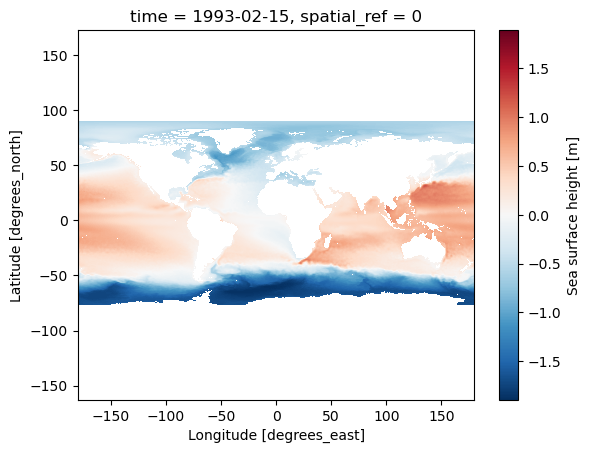

In [26]:
f,ax1=plt.subplots()
out['zos'][0].plot(ax=ax1)
ax1.axis('equal');

In [32]:
flat_vars = ["zos","mlotst","bottomT","sithick","siconc","usi","vsi"]

month_datasets = [data_dict[month][flat_vars] for month in sorted(data_dict.keys())]

In [37]:
for ds in month_datasets:
    print(ds.dims)

Frozen({'time': 1, 'latitude': 2041, 'longitude': 4320})
Frozen({'time': 1, 'latitude': 2041, 'longitude': 4320})
Frozen({'time': 1, 'latitude': 2041, 'longitude': 4320})
Frozen({'time': 1, 'latitude': 2041, 'longitude': 4320})
Frozen({'time': 1, 'latitude': 2041, 'longitude': 4320})
Frozen({'time': 1, 'latitude': 2041, 'longitude': 4320})
Frozen({'time': 1, 'latitude': 2041, 'longitude': 4320})
Frozen({'time': 1, 'latitude': 2041, 'longitude': 4320})
Frozen({'time': 1, 'latitude': 2041, 'longitude': 4320})
Frozen({'time': 1, 'latitude': 2041, 'longitude': 4320})
Frozen({'time': 1, 'latitude': 2041, 'longitude': 4320})
Frozen({'time': 1, 'latitude': 2041, 'longitude': 4320})


In [42]:
month_datasets[:1][0]

<xarray.Dataset>
Dimensions:      (time: 1, latitude: 2041, longitude: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1993-01-16T12:00:00
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude     (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
    spatial_ref  int64 0
Data variables:
    zos          (time, latitude, longitude) float32 ...
    mlotst       (time, latitude, longitude) float32 ...
    bottomT      (time, latitude, longitude) float32 ...
    sithick      (time, latitude, longitude) float32 ...
    siconc       (time, latitude, longitude) float32 ...
    usi          (time, latitude, longitude) float32 ...
    vsi          (time, latitude, longitude) float32 ...
Attributes: (12/16)
    CDI:                           Climate Data Interface version 1.9.3 (http...
    source:                        MERCATOR GLORYS12V1
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    CDO:                           Climate Data Operators version 1.9.3 (http...
    title:                         Monthly climatology fields for product GLO...
    dataset:                       global-reanalysis-phy-001-030-monthly-clim...

In [63]:
one = data_dict["mercatorglorys12v1_gl12_mean_1993_2016_02"][flat_vars]
two = data_dict["mercatorglorys12v1_gl12_mean_1993_2016_01"][flat_vars]
xa.concat([one,two], dim="time")

<xarray.Dataset>
Dimensions:      (time: 2, latitude: 2041, longitude: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1993-02-15 1993-01-16T12:00:00
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude     (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
    spatial_ref  int64 0
Data variables:
    zos          (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    mlotst       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    bottomT      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    sithick      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    siconc       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    usi          (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    vsi          (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/16)
    CDI:                           Climate Data Interface version 1.9.3 (http...
    source:                        MERCATOR GLORYS12V1
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    CDO:                           Climate Data Operators version 1.9.3 (http...
    title:                         Monthly climatology fields for product GLO...
    dataset:                       global-reanalysis-phy-001-030-monthly-clim...

In [72]:
# 1D variables
flat_vars = ["zos","mlotst","bottomT","sithick","siconc","usi","vsi"]

month_datasets = [data_dict[month][flat_vars] for month in sorted(data_dict.keys())]
# month_datasets[2]
flat_vars_ds = xa.concat(month_datasets, dim='time')

In [73]:
flat_vars_ds

<xarray.Dataset>
Dimensions:      (time: 12, latitude: 2041, longitude: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1993-01-16T12:00:00 ... 1993-12-16T12:...
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * latitude     (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
    spatial_ref  int64 0
Data variables:
    zos          (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    mlotst       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    bottomT      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    sithick      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    siconc       (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    usi          (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    vsi          (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/16)
    CDI:                           Climate Data Interface version 1.9.3 (http...
    source:                        MERCATOR GLORYS12V1
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    ...                            ...
    product:                       GLOBAL_REANALYSIS_001_030
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    CDO:                           Climate Data Operators version 1.9.3 (http...
    title:                         Monthly climatology fields for product GLO...
    dataset:                       global-reanalysis-phy-001-030-monthly-clim...

(-180.04165649414062,
 179.95834350585938,
 -80.04167175292969,
 90.04167175292969)

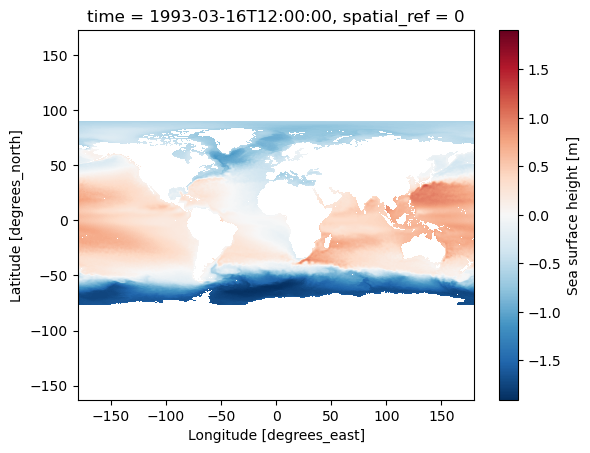

In [19]:
# f,ax1=plt.subplots()
# surface_monthly_means['zos'][0].plot(ax=ax1)
# ax1.axis('equal');


In [14]:
import numpy as np
import xarray as xr

# create x and y coordinates
x = np.arange(0, 4320, 1)
y = np.arange(0, 20410, 1)

# create time coordinate
da1_time = np.arange('2022-01', '2022-03', dtype='datetime64[M]')
da1_time = np.arange('2022-03', '2022-04', dtype='datetime64[M]')


# create data for the first DataArray
data1 = np.random.rand(len(time), len(y), len(x))

# create the first DataArray
da1 = xr.DataArray(data1, coords=[time, y, x], dims=['time', 'y', 'x'])

# create data for the second DataArray
data2 = np.random.rand(len(time), len(y), len(x))

# create the second DataArray
da2 = xr.DataArray(data2, coords=[time, y, x], dims=['time', 'y', 'x'])


In [15]:
xa.concat([da1, da2], dim="time")

<xarray.DataArray (time: 4, y: 20410, x: 4320)>
array([[[0.75446835, 0.1077007 , 0.83572597, ..., 0.99669341,
         0.53840844, 0.51530264],
        [0.99475896, 0.26677805, 0.34716041, ..., 0.02045218,
         0.17040128, 0.35679139],
        [0.41618011, 0.9198929 , 0.57216172, ..., 0.4026489 ,
         0.66796316, 0.84042253],
        ...,
        [0.92230663, 0.80044678, 0.08935449, ..., 0.08823734,
         0.48786745, 0.45153842],
        [0.82382074, 0.70327413, 0.02286299, ..., 0.40045327,
         0.88163198, 0.86080518],
        [0.97576489, 0.27097627, 0.9303678 , ..., 0.79159236,
         0.88670405, 0.45009256]],

       [[0.27809056, 0.17692736, 0.59751268, ..., 0.09049337,
         0.57229905, 0.00660646],
        [0.03532181, 0.79317998, 0.07008522, ..., 0.2621877 ,
         0.64696831, 0.72493919],
        [0.9392924 , 0.24442007, 0.2307378 , ..., 0.99305975,
         0.87871787, 0.37262284],
...
        [0.19516553, 0.51793777, 0.29385983, ..., 0.58382697,
         0.27058066, 0.59308107],
        [0.92300496, 0.69248648, 0.09063369, ..., 0.89966452,
         0.43486407, 0.35947361],
        [0.11152875, 0.84154115, 0.80704548, ..., 0.4070193 ,
         0.36909501, 0.69173586]],

       [[0.80092593, 0.72450424, 0.73688117, ..., 0.76431329,
         0.021606  , 0.86351049],
        [0.2021653 , 0.3692956 , 0.01083253, ..., 0.5592802 ,
         0.26909847, 0.61256197],
        [0.9604709 , 0.76628189, 0.07159815, ..., 0.94172555,
         0.68190425, 0.64327801],
        ...,
        [0.1072077 , 0.87800347, 0.37265572, ..., 0.24425241,
         0.99463744, 0.12636317],
        [0.31415079, 0.36259078, 0.97561282, ..., 0.20646006,
         0.48214793, 0.14101504],
        [0.56495235, 0.93062248, 0.38881486, ..., 0.33366138,
         0.68006542, 0.67867932]]])
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-02-01 2022-01-01 2022-02-01
  * y        (y) int64 0 1 2 3 4 5 6 ... 20404 20405 20406 20407 20408 20409
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319

In [36]:
month_datasets = [data_dict[month] for month in sorted(data_dict.keys())]
# month_datasets[2]
concat_data = xa.concat(month_datasets[2:3], dim='time')
# sorted_data = concat_data.sortby('time')


KeyboardInterrupt: 

8it [00:14,  1.76s/it]


RuntimeError: NetCDF: HDF error

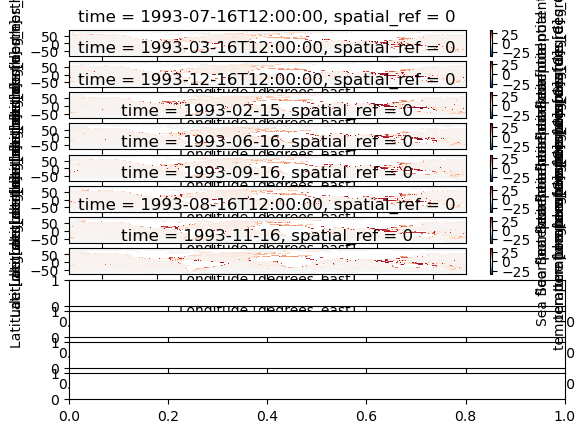

In [8]:
fig, ax = plt.subplots(12, 1)

for i, array in tqdm(enumerate(out.values())):
    # reduced_array = reduce_xa_array(array, resolution=1)
    array["bottomT"].plot(ax=ax[i])

# reduced_array["bottomT"].plot(ax=ax[i])

In [ ]:
fig, ax = plt.subplots(len(out), 1)

for i, array in tqdm(enumerate(out.values())):
    array["mlotst"].plot(ax=ax[i])

ERROR:tornado.general:SEND Error: Host unreachable
12it [00:23,  1.94s/it]


Error in callback <function _draw_all_if_interactive at 0x14e647a60> (for post_execute):


KeyboardInterrupt: 

In [ ]:
reduce_xa_array(out["mercatorglorys12v1_gl12_mean_1993_2016_05"]['mlotst'])

KeyboardInterrupt: 

In [ ]:
(reduce_xa_array(out["mercatorglorys12v1_gl12_mean_1993_2016_05"]['mlotst'])).plot()

KeyboardInterrupt: 

In [ ]:
out["mercatorglorys12v1_gl12_mean_1993_2016_08"].variables.keys()

KeysView(Frozen({'time': <xarray.IndexVariable 'time' (time: 1)>
array(['1993-08-16T12:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    standard_name:  time
    long_name:      Time (hours since 1950-01-01)
    axis:           T, 'longitude': <xarray.IndexVariable 'longitude' (longitude: 4320)>
array([-180.     , -179.91667, -179.83333, ...,  179.75   ,  179.83333,
        179.91667], dtype=float32)
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    axis:           X, 'latitude': <xarray.IndexVariable 'latitude' (latitude: 2041)>
array([-80.      , -79.916664, -79.833336, ...,  89.833336,  89.916664,
        90.      ], dtype=float32)
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north
    axis:           Y, 'depth': <xarray.IndexVariable 'depth' (depth: 50)>
array([4.940250e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00, 5.078224e+00,
       6.440614e+00, 7.929560e+00

In [ ]:
out["mercatorglorys12v1_gl12_mean_1993_2016_07"].variables["usi"][:][0]

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [0.01104770042002201, 0.01110873743891716, 0.011139255948364735,
         ..., 0.010925626382231712, 0.010986663401126862,
         0.011017181910574436],
        [0.0038453321903944016, 0.003875850699841976,
         0.003906369209289551, ..., 0.0036927396431565285,
         0.0037537766620516777, 0.0037842951714992523],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-32767,
  dtype=float32)

## Ocean Acidification

In [ ]:
acids = read_ncs_from_dir("/Volumes/MRes Drive/ocean_acidification")

100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


In [ ]:
acids["Aragonite_std_historical"]

<xarray.Dataset>
Dimensions:    (time: 18, lat: 180, lon: 360)
Coordinates:
  * time       (time) float64 1.75e+03 1.85e+03 1.86e+03 ... 2e+03 2.01e+03
Dimensions without coordinates: lat, lon
Data variables:
    aragonite  (time, lat, lon) float64 ...
    longitude  (lat, lon) float64 ...
    latitude   (lat, lon) float64 ...
Attributes:
    title:               Standard deviations of global surface ocean aragonit...
    comment:             This gridded data product contains the standard devi...
    reference:           Jiang, L-Q., J. Dunne, B. R. Carter, J. Tjiputra,\n ...
    Fair_use_statement:  This data product is made freely available\n   to th...
    created_by:          Li-Qing Jiang
    institution:         (a) Cooperative Institute for Satellite Earth System...
    contact:             <Liqing.Jiang@noaa.gov>
    creation_date:       August 14, 2022